## Final Project Submission

* Student name: Hoang Nguyen, Madoria Thomas, Marcelo Scatena
* Student pace: full time
* Scheduled project review date: 07/01/2021
* Instructor name: Skyler English


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels
from statsmodels.formula.api import ols
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from yellowbrick.model_selection import RFECV
from yellowbrick.features import Rank2D
from ipynb.fs.full.cleaning_data import clean_data
from geopy import distance
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data/kc_house_data.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

### Split Data into Test and Train

In [4]:
X = df.drop('price', axis=1)
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=42)

In [5]:
# We'll use df as our train dataset
y = y_train
X_train['price'] = y
df = X_train

### Find out where my missing values and fill them to make a first model with all the information we can:

In [6]:
df.isnull().sum()

id                  0
date                0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       1897
view               53
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3059
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
price               0
dtype: int64

In [7]:
df['view'].value_counts()

NONE         15556
AVERAGE        753
GOOD           395
EXCELLENT      263
FAIR           257
Name: view, dtype: int64

In [8]:
df['view'].fillna('NONE', inplace=True)

In [9]:
df['waterfront'].value_counts()

NO     15262
YES      118
Name: waterfront, dtype: int64

In [10]:
df['waterfront'].fillna('NO', inplace=True)

In [11]:
df['yr_renovated'].value_counts() 

0.0       13625
2014.0       56
2005.0       27
2007.0       24
2003.0       24
          ...  
1976.0        1
1959.0        1
1953.0        1
1950.0        1
1954.0        1
Name: yr_renovated, Length: 68, dtype: int64

In [12]:
df['yr_renovated'].fillna(0.0, inplace=True)

### Change all our objects into numeric values:

In [13]:
# Convert grade to int
df['grade'] = df['grade'].apply(lambda x: x[:2] if x[0]=='1' else x[:1]).astype('int64')

In [14]:
# Remove ? and convert sqft_basement to int
df['sqft_basement'] = df['sqft_basement'].apply(lambda x: 0 if x=='?' else int(x.split('.')[0]))

In [15]:
# Change waterfront to numeric
df['waterfront'] = df['waterfront'].apply(lambda x: 1 if x=='YES' else 0)

In [16]:
df['view'].unique()

array(['NONE', 'AVERAGE', 'GOOD', 'EXCELLENT', 'FAIR'], dtype=object)

In [17]:
# Change view to numeric
df['view'] = df['view'].apply(lambda x: 0 if x=='NONE' else (1 if x=='FAIR' else (2 if x=='AVERAGE' else (3 if x=='GOOD' else 4))))

In [18]:
df['condition'].unique()

array(['Good', 'Average', 'Very Good', 'Fair', 'Poor'], dtype=object)

In [19]:
# Change condition to numeric
df['condition'] = df['condition'].apply(lambda x: 1 if x=='Poor' else (2 if x=='Fair' else (3 if x=='Average' else (4 if x=='Good' else 5))))

In [20]:
#Convert date column to 2 separate columns for month and year
date = df['date'].str.split('/', expand=True)
df['month_sold'] = date[0].astype('int64')
df['year_sold'] = date[2].astype('int64')

#Drop original date column
df.drop(columns=['date'], axis=1, inplace=True)

In [21]:
df.head()

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price,month_sold,year_sold
6243,9834201100,4,2.00,1440,4855,2.0,0,0,4,7,...,1972,0.0,98144,47.5717,-122.287,1300,4080,332500.0,12,2014
8986,7795810110,3,1.75,1430,9857,1.0,0,2,4,7,...,1980,0.0,98045,47.4964,-121.771,1310,9880,390000.0,5,2015
9419,1853081250,4,2.75,3120,5000,2.0,0,0,3,9,...,2010,0.0,98074,47.5940,-122.062,3200,5000,800000.0,12,2014
10155,2558630350,4,2.50,2060,6958,1.0,0,0,3,7,...,1974,0.0,98034,47.7251,-122.168,1760,7350,462000.0,3,2015
10436,3362401000,3,2.00,2500,4080,1.5,0,0,5,7,...,1922,0.0,98103,47.6813,-122.346,1550,3060,695000.0,7,2014


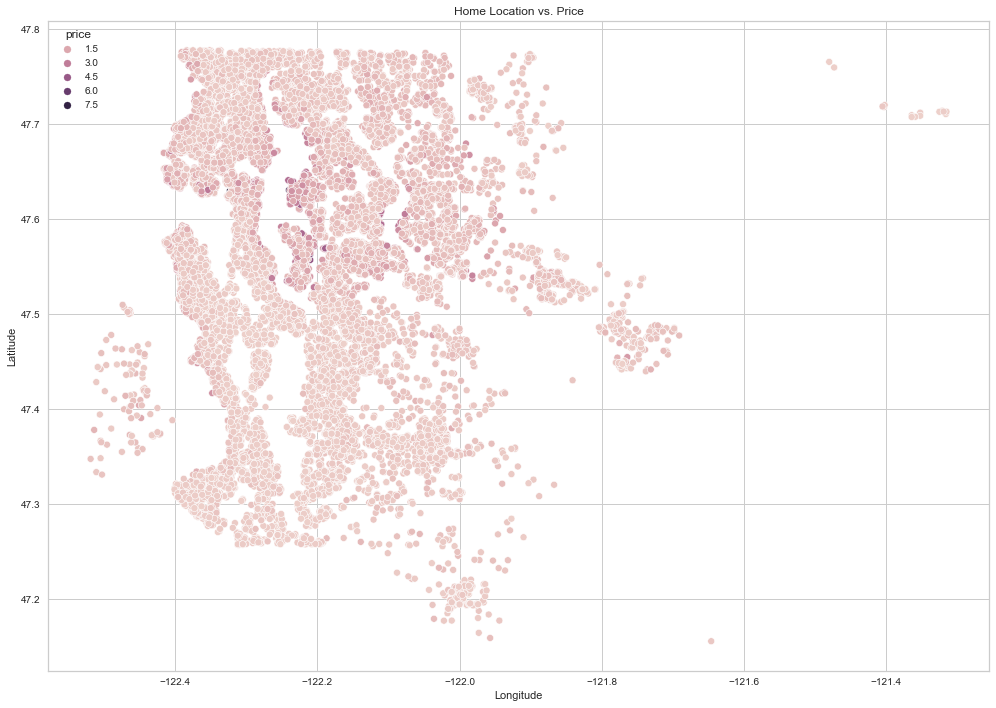

In [22]:
plt.figure(figsize=(14, 10))
plt.title('Home Location vs. Price')
sns.scatterplot(df['long'], df['lat'], hue=df['price'])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
# plt.legend()
plt.tight_layout()

# Model 1 - Using All Features

In [23]:
X = df.drop('price', axis=1)
y = df['price']
model = sm.OLS(y, sm.add_constant(X)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.703
Model:                            OLS   Adj. R-squared:                  0.703
Method:                 Least Squares   F-statistic:                     1946.
Date:                Tue, 04 Jan 2022   Prob (F-statistic):               0.00
Time:                        23:05:20   Log-Likelihood:            -2.3549e+05
No. Observations:               17277   AIC:                         4.710e+05
Df Residuals:                   17255   BIC:                         4.712e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -7.024e+07   1.11e+07     -6.316      0.000    -9.2e+07   -4.84e+07
id            -1.756e-06   5.38e-07     -3.262      0.001   -2.81e-06   -7.01e-07
bedrooms      -3.898e+04   2208.241    -17.652      0.000   -4.33e+04   -3.47e+04
bathrooms      4.258e+04   3669.369     11.605      0.000    3.54e+04    4.98e+04
sqft_living     101.3979     21.483      4.720      0.000      59.289     143.507
sqft_lot          0.0878      0.055      1.606      0.108      -0.019       0.195
floors         9946.9534   4024.590      2.472      0.013    2058.348    1.78e+04
waterfront     6.041e+05   2.02e+04     29.925      0.000    5.65e+05    6.44e+05
view           5.253e+04   2374.225     22.125      0.000    4.79e+04    5.72e+04
condition       2.98e+04   2626.080     11.347      0.000    2.47e+04    3.49e+04
grade          9.905e+04   2415.860     41.002      0.000    9.43e+04    1.04e+05
sqft_above       78.2646     21.420      3.654      0.000      36.279     120.250
sqft_basement    52.3378     21.253      2.463      0.014      10.679      93.996
yr_built      -2696.8508     80.408    -33.540      0.000   -2854.459   -2539.243
yr_renovated     22.9471      4.454      5.152      0.000      14.217      31.678
zipcode        -564.7472     36.869    -15.318      0.000    -637.014    -492.480
lat            5.897e+05    1.2e+04     49.016      0.000    5.66e+05    6.13e+05
long          -2.078e+05   1.46e+04    -14.210      0.000   -2.36e+05   -1.79e+05
sqft_living15    24.7295      3.883      6.369      0.000      17.119      32.340
sqft_lot15       -0.4617      0.082     -5.631      0.000      -0.622      -0.301
month_sold     1435.9748    789.356      1.819      0.069    -111.243    2983.192
year_sold      3.812e+04   5268.577      7.235      0.000    2.78e+04    4.84e+04
==============================================================================
Omnibus:                    14849.799   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1493773.020
Skew:                           3.630   Prob(JB):                         0.00
Kurtosis:                      47.970   Cond. No.                     3.94e+13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.94e+13. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### The first model has an adjusted r-squared of 0.703, with a few insignificant values (P-Values > 0.05).

## Normality

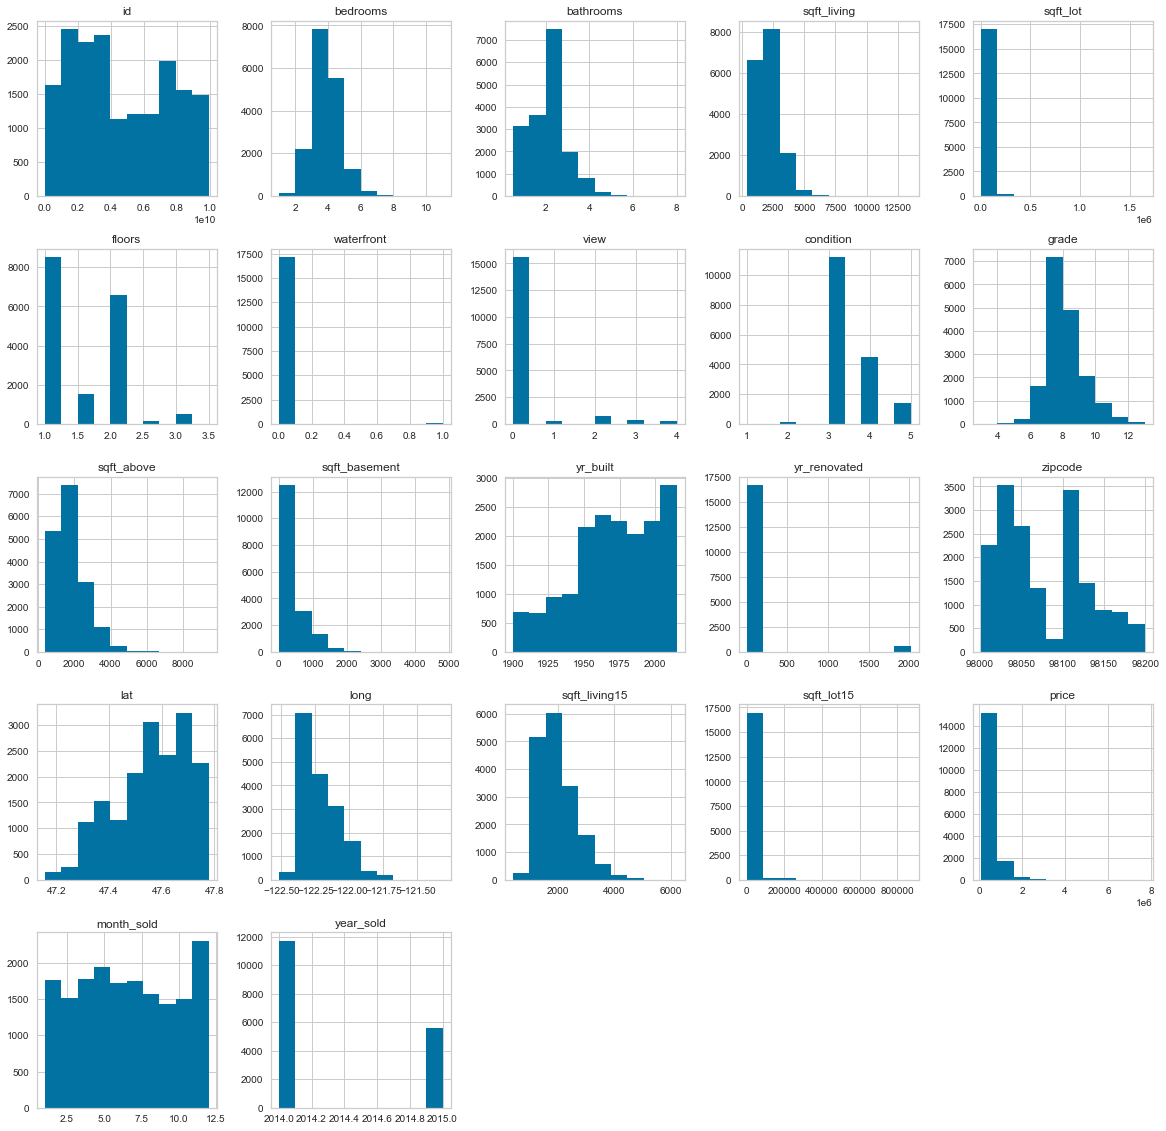

In [24]:
df.hist(figsize=(20,20));

None of these variables seem to follow a normal distribution. While this may create problems satisfying all assumptions, we'll first take a look at the other assumptions to see if there are any obvious changes to me made.

For now we'll use a QQ Plot to confirm that our assesment is correct.

<Figure size 864x576 with 0 Axes>

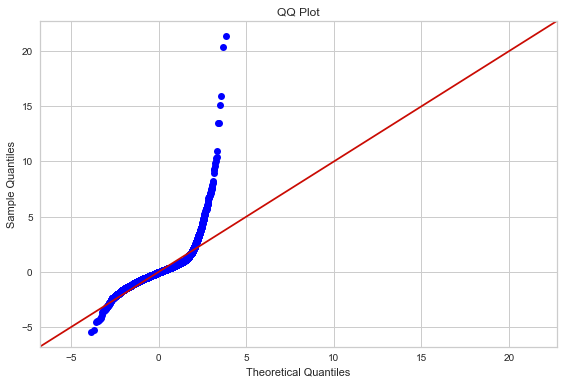

In [25]:
plt.figure(figsize=(12, 8))
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)
plt.title('QQ Plot')
plt.tight_layout();

## The next step we'll implement changes regarding our business question

In [26]:
df['bedrooms'].value_counts()

3     7836
4     5542
2     2189
5     1281
6      216
1      161
7       35
8       10
9        4
10       2
11       1
Name: bedrooms, dtype: int64

In [27]:
# Remove the few houses with high number of bedrooms
df = df[~df['bedrooms'].isin([11, 10, 9])]

In [28]:
# Removing features not pertinent to our business question or with too many unknown values
# df.drop(['id', 'year_sold', 'month_sold', 'yr_renovated', 'view', 'waterfront'], axis=1, inplace=True)

#### Turn Bathrooms column into wc_comp and wc_inc:

In [29]:
df['bathrooms'].value_counts()

2.50    4322
1.00    3076
1.75    2446
2.25    1646
2.00    1526
1.50    1168
2.75     933
3.00     593
3.50     583
3.25     465
3.75     120
4.00     111
4.50      82
4.25      66
0.75      59
4.75      20
5.00      17
5.25       9
1.25       5
5.50       5
0.50       4
5.75       3
6.00       3
8.00       2
6.75       2
6.50       2
7.75       1
6.25       1
Name: bathrooms, dtype: int64

In [30]:
df['bathrooms'] = df['bathrooms'].apply(lambda x: np.ceil(x) if str(x)[2] == '7' else (np.ceil(x) if str(x)[2] == '5' else np.floor(x)))

In [31]:
df['bathrooms'].value_counts()

2.0    6786
3.0    6313
1.0    3144
4.0     880
5.0     128
6.0      12
7.0       4
8.0       3
Name: bathrooms, dtype: int64

In [32]:
df = df[~df['bathrooms'].isin([8.0, 7.0])]

#### Changed Floor column:

In [33]:
df['floors'].value_counts()

1.0    8530
2.0    6571
1.5    1532
3.0     498
2.5     125
3.5       7
Name: floors, dtype: int64

In [34]:
df['floors'] = df['floors'].apply(lambda x: np.ceil(x))

# Model 2 - Changing price target and removing features

In [35]:
X = df.drop('price', axis=1)
y = df['price']
model = sm.OLS(y, sm.add_constant(X)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.704
Model:                            OLS   Adj. R-squared:                  0.704
Method:                 Least Squares   F-statistic:                     1955.
Date:                Tue, 04 Jan 2022   Prob (F-statistic):               0.00
Time:                        23:05:25   Log-Likelihood:            -2.3484e+05
No. Observations:               17263   AIC:                         4.697e+05
Df Residuals:                   17241   BIC:                         4.699e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -7.129e+07   1.08e+07     -6.583      0.000   -9.25e+07   -5.01e+07
id            -1.947e-06   5.24e-07     -3.714      0.000   -2.98e-06    -9.2e-07
bedrooms       -3.29e+04   2172.160    -15.144      0.000   -3.72e+04   -2.86e+04
bathrooms      1.236e+04   2999.710      4.120      0.000    6480.319    1.82e+04
sqft_living     113.0153     20.879      5.413      0.000      72.091     153.939
sqft_lot          0.1114      0.053      2.094      0.036       0.007       0.216
floors         1.907e+04   3447.364      5.533      0.000    1.23e+04    2.58e+04
waterfront     6.046e+05   1.97e+04     30.647      0.000    5.66e+05    6.43e+05
view           5.145e+04   2313.630     22.237      0.000    4.69e+04     5.6e+04
condition      3.149e+04   2556.321     12.317      0.000    2.65e+04    3.65e+04
grade          1.024e+05   2353.808     43.514      0.000    9.78e+04    1.07e+05
sqft_above       62.9770     20.841      3.022      0.003      22.127     103.827
sqft_basement    47.7235     20.693      2.306      0.021       7.162      88.285
yr_built      -2423.1190     77.055    -31.447      0.000   -2574.155   -2272.083
yr_renovated     24.5613      4.334      5.667      0.000      16.066      33.057
zipcode        -558.3733     35.896    -15.555      0.000    -628.733    -488.014
lat            5.926e+05   1.17e+04     50.644      0.000     5.7e+05    6.16e+05
long          -2.079e+05   1.42e+04    -14.628      0.000   -2.36e+05    -1.8e+05
sqft_living15    30.8817      3.807      8.111      0.000      23.419      38.344
sqft_lot15       -0.4591      0.080     -5.750      0.000      -0.616      -0.303
month_sold     1328.8151    768.792      1.728      0.084    -178.095    2835.726
year_sold      3.798e+04   5131.313      7.401      0.000    2.79e+04     4.8e+04
==============================================================================
Omnibus:                    12481.153   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           568779.470
Skew:                           2.980   Prob(JB):                         0.00
Kurtosis:                      30.481   Cond. No.                     3.94e+13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.94e+13. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Variable Correlations

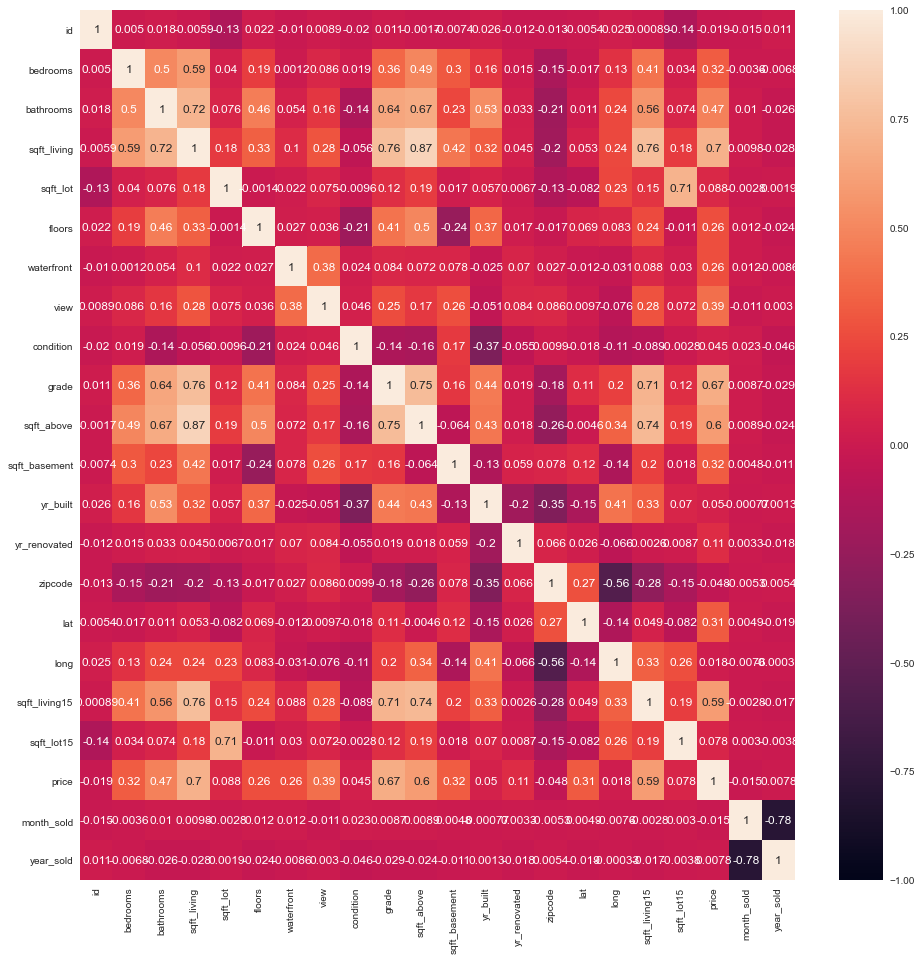

In [36]:
fig, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True);

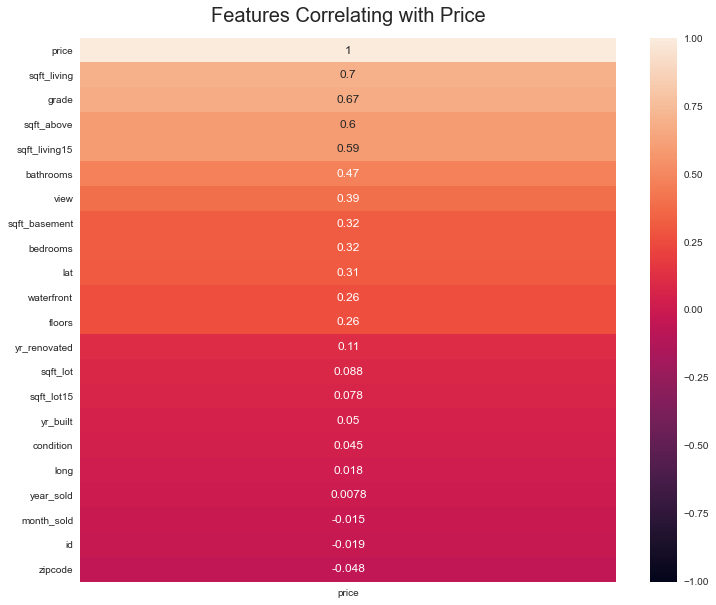

In [37]:
fig, ax = plt.subplots(figsize=(12, 10))
heatmap = sns.heatmap(df.corr()[['price']].sort_values(by='price', ascending=False), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Features Correlating with Price', fontdict={'fontsize':20}, pad=16);

Of the features most correlated with Price, a few of them are regarding to the size of the property and surrounding ones (sqft_living, sqft_living15, sqft_above, number of bathrooms)

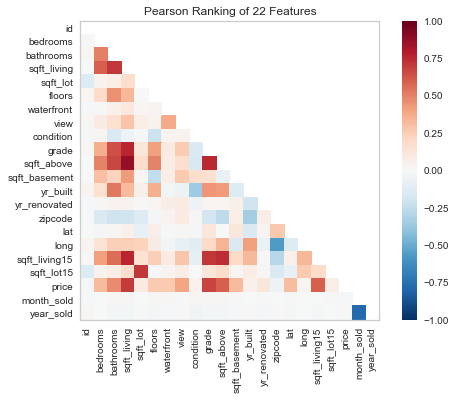

In [38]:
visualizer = Rank2D(algorithm="pearson")
visualizer.fit_transform(df)
visualizer.show();

In [39]:
# Drop some highly correlated columns
df.drop(['grade', 'sqft_above', 'sqft_living15', 'sqft_lot15'], axis=1, inplace=True)

In [40]:
# Drop uncorrelated columns
df.drop(['id', 'year_sold', 'month_sold', 'zipcode'], axis=1, inplace=True)

# Model 3 - Addressing multicolinearity and dropping insignificant values

In [41]:
X = df.drop('price', axis=1)
y = df['price']
model = sm.OLS(y, sm.add_constant(X)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.655
Model:                            OLS   Adj. R-squared:                  0.655
Method:                 Least Squares   F-statistic:                     2518.
Date:                Tue, 04 Jan 2022   Prob (F-statistic):               0.00
Time:                        23:05:31   Log-Likelihood:            -2.3617e+05
No. Observations:               17263   AIC:                         4.724e+05
Df Residuals:                   17249   BIC:                         4.725e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -4.811e+07   1.77e+06    -27.122      0.000   -5.16e+07   -4.46e+07
bedrooms      -4.659e+04   2312.629    -20.147      0.000   -5.11e+04   -4.21e+04
bathrooms      2.184e+04   3228.232      6.764      0.000    1.55e+04    2.82e+04
sqft_living     295.2460      3.184     92.739      0.000     289.006     301.486
sqft_lot         -0.1144      0.042     -2.714      0.007      -0.197      -0.032
floors         1.987e+04   3646.236      5.451      0.000    1.27e+04     2.7e+04
waterfront     5.754e+05   2.13e+04     27.039      0.000    5.34e+05    6.17e+05
view           6.594e+04   2437.126     27.055      0.000    6.12e+04    7.07e+04
condition      3.585e+04   2737.031     13.099      0.000    3.05e+04    4.12e+04
sqft_basement   -65.2062      4.915    -13.268      0.000     -74.839     -55.573
yr_built      -1385.1407     80.045    -17.304      0.000   -1542.038   -1228.244
yr_renovated     30.4679      4.671      6.523      0.000      21.312      39.624
lat            6.535e+05   1.21e+04     53.900      0.000     6.3e+05    6.77e+05
long          -1.607e+05   1.34e+04    -11.980      0.000   -1.87e+05   -1.34e+05
==============================================================================
Omnibus:                    11066.906   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           347975.256
Skew:                           2.597   Prob(JB):                         0.00
Kurtosis:                      24.373   Cond. No.                     4.72e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.72e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Feature Engineering

In [42]:
lat_long = df['lat'].astype(str) + ',' + df['long'].astype(str)
lat_long = list(map(eval, lat_long))
Seattle = (47.6062, -122.3321)
Redmond = (47.6740, -122.1215)
miles_s = []
miles_r = []
for i in lat_long:
    miles_s.append(round(distance.distance(i, Seattle).miles, 1))
for i in lat_long:
    miles_r.append(round(distance.distance(i, Redmond).miles, 1))
df['distance_seattle'] = miles_s
df['distance_redmond'] = miles_r

Since we created new columns using location information, we can drop the latitude, longitude and zipcode columns.

In [43]:
df.drop(['lat', 'long'], axis=1, inplace=True)

# Model 4 - With Feature Engineering Done

In [44]:
X = df.drop('price', axis=1)
y = df['price']
model = sm.OLS(y, sm.add_constant(X)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.690
Model:                            OLS   Adj. R-squared:                  0.690
Method:                 Least Squares   F-statistic:                     2953.
Date:                Tue, 04 Jan 2022   Prob (F-statistic):               0.00
Time:                        23:05:40   Log-Likelihood:            -2.3524e+05
No. Observations:               17263   AIC:                         4.705e+05
Df Residuals:                   17249   BIC:                         4.706e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              1.71e+06   1.54e+05     11.117      0.000    1.41e+06    2.01e+06
bedrooms         -4.564e+04   2190.370    -20.836      0.000   -4.99e+04   -4.13e+04
bathrooms         1.703e+04   3062.872      5.561      0.000     1.1e+04     2.3e+04
sqft_living        292.7164      3.045     96.117      0.000     286.747     298.686
sqft_lot             0.1945      0.040      4.829      0.000       0.116       0.273
floors            3845.8878   3533.913      1.088      0.276   -3080.941    1.08e+04
waterfront        5.769e+05   2.02e+04     28.592      0.000    5.37e+05    6.16e+05
view              6.579e+04   2315.209     28.417      0.000    6.13e+04    7.03e+04
condition         3.716e+04   2592.413     14.333      0.000    3.21e+04    4.22e+04
sqft_basement      -84.4621      4.705    -17.950      0.000     -93.685     -75.239
yr_built          -785.3175     78.137    -10.051      0.000    -938.473    -632.162
yr_renovated        33.5666      4.427      7.582      0.000      24.888      42.245
distance_seattle -1.273e+04    361.558    -35.219      0.000   -1.34e+04    -1.2e+04
distance_redmond -7908.3023    301.647    -26.217      0.000   -8499.560   -7317.044
==============================================================================
Omnibus:                    11597.002   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           422176.344
Skew:                           2.734   Prob(JB):                         0.00
Kurtosis:                      26.601   Cond. No.                     4.32e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.32e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Extended EDA

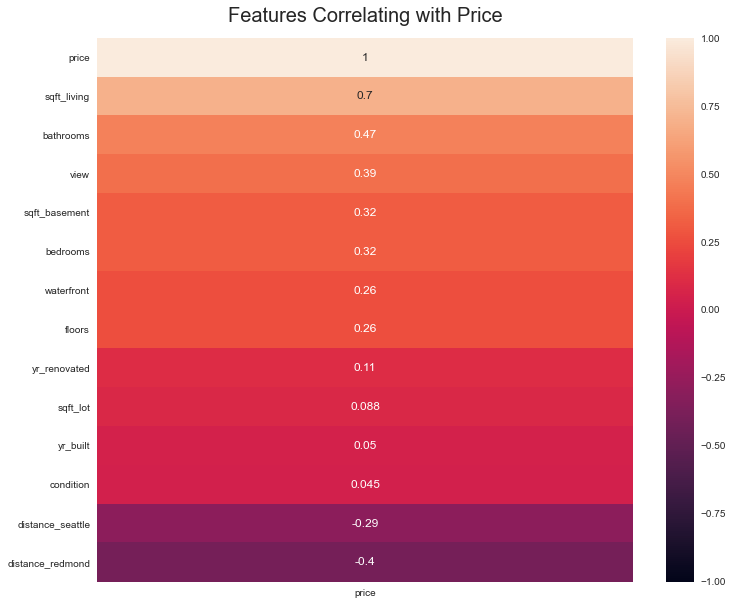

In [45]:
fig, ax = plt.subplots(figsize=(12, 10))
heatmap = sns.heatmap(df.corr()[['price']].sort_values(by='price', ascending=False), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Features Correlating with Price', fontdict={'fontsize':20}, pad=16);

In [46]:
# Drop some highly correlated columns
df.drop(['condition', 'yr_built', 'sqft_lot', 'yr_renovated'], axis=1, inplace=True)

## Model 5

In [47]:
X = df.drop('price', axis=1)
y = df['price']
model = sm.OLS(y, sm.add_constant(X)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.680
Model:                            OLS   Adj. R-squared:                  0.680
Method:                 Least Squares   F-statistic:                     4067.
Date:                Tue, 04 Jan 2022   Prob (F-statistic):               0.00
Time:                        23:05:41   Log-Likelihood:            -2.3552e+05
No. Observations:               17263   AIC:                         4.711e+05
Df Residuals:                   17253   BIC:                         4.711e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             3.372e+05   7828.571     43.075      0.000    3.22e+05    3.53e+05
bedrooms         -4.135e+04   2200.786    -18.787      0.000   -4.57e+04    -3.7e+04
bathrooms        -1173.9730   2816.874     -0.417      0.677   -6695.333    4347.387
sqft_living        296.3577      3.049     97.197      0.000     290.381     302.334
floors           -8627.1409   3533.018     -2.442      0.015   -1.56e+04   -1702.068
waterfront         5.92e+05   2.05e+04     28.906      0.000    5.52e+05    6.32e+05
view              6.946e+04   2344.692     29.623      0.000    6.49e+04    7.41e+04
sqft_basement      -73.0223      4.748    -15.379      0.000     -82.329     -63.715
distance_seattle -1.445e+04    329.137    -43.901      0.000   -1.51e+04   -1.38e+04
distance_redmond -7040.3985    301.285    -23.368      0.000   -7630.948   -6449.849
==============================================================================
Omnibus:                    11250.054   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           363790.010
Skew:                           2.652   Prob(JB):                         0.00
Kurtosis:                      24.855   Cond. No.                     3.03e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.03e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [48]:
# Drop insignificant values (P-value higher than 0.05)
# df.drop(['bathrooms'], axis=1, inplace=True)

In [49]:
# df.drop(['sqft_basement'], axis=1, inplace=True)

In [50]:
df.drop(['view'], axis=1, inplace=True)

In [51]:
# df.drop(['waterfront'], axis=1, inplace=True)

In [52]:
X = df.drop('price', axis=1)
y = df['price']
model = sm.OLS(y, sm.add_constant(X)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.663
Model:                            OLS   Adj. R-squared:                  0.663
Method:                 Least Squares   F-statistic:                     4250.
Date:                Tue, 04 Jan 2022   Prob (F-statistic):               0.00
Time:                        23:05:41   Log-Likelihood:            -2.3595e+05
No. Observations:               17263   AIC:                         4.719e+05
Df Residuals:                   17254   BIC:                         4.720e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             3.337e+05   8024.013     41.583      0.000    3.18e+05    3.49e+05
bedrooms         -4.753e+04   2245.838    -21.162      0.000   -5.19e+04   -4.31e+04
bathrooms        -1907.2007   2887.425     -0.661      0.509   -7566.847    3752.445
sqft_living        313.8883      3.066    102.374      0.000     307.878     319.898
floors           -9501.5785   3621.518     -2.624      0.009   -1.66e+04   -2403.035
waterfront        8.117e+05   1.96e+04     41.483      0.000    7.73e+05     8.5e+05
sqft_basement      -57.0946      4.836    -11.806      0.000     -66.574     -47.615
distance_seattle -1.561e+04    334.995    -46.598      0.000   -1.63e+04    -1.5e+04
distance_redmond -5939.1904    306.483    -19.379      0.000   -6539.928   -5338.452
==============================================================================
Omnibus:                    10838.836   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           295068.697
Skew:                           2.568   Prob(JB):                         0.00
Kurtosis:                      22.592   Cond. No.                     2.82e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.82e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [53]:
import statsmodels.formula.api as smf

In [54]:
def model_diagnostic(model, x, x_name, y):
    
    residuals = model.resid
    
    f = plt.figure()
    f, axes = plt.subplots(nrows = 1, ncols = 3, sharex=False, sharey = False, figsize=(65,20), squeeze=False)
    
    f.text(s="Model Diagnostic Summary", x=.40, y=1.15, fontsize=65, fontname='silom')
    f.text(s="r-Squared: {r}".format(r=round(model.rsquared, 2)), x=.40, y=1.05, fontsize=50, fontname='serif')
    f.text(s="p-value: {p}".format(p= model.f_pvalue), x=.53, y=1.05, fontsize=50, fontname='serif')
    
    f.text(s='Residuals Histogram', x=.45, y=.93, fontsize=55, fontname='serif')
    
    sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True, ax=axes[0][0])    
    plt.show;
    
    f.text(s='QQ Plot', x=.20, y=.93, fontsize=55, fontname='serif')
    
    axes[0][1].hist(residuals)
    plt.show;
    
    sns.residplot(x, y, ax=axes[0][2])
 
    f.text(s='Residuals vs {x}'.format(x=x_name), x=.73, y=.93, fontsize=55, fontname='serif')
    plt.tight_layout;
    plt.show;

<Figure size 576x396 with 0 Axes>

findfont: Font family ['silom'] not found. Falling back to DejaVu Sans.


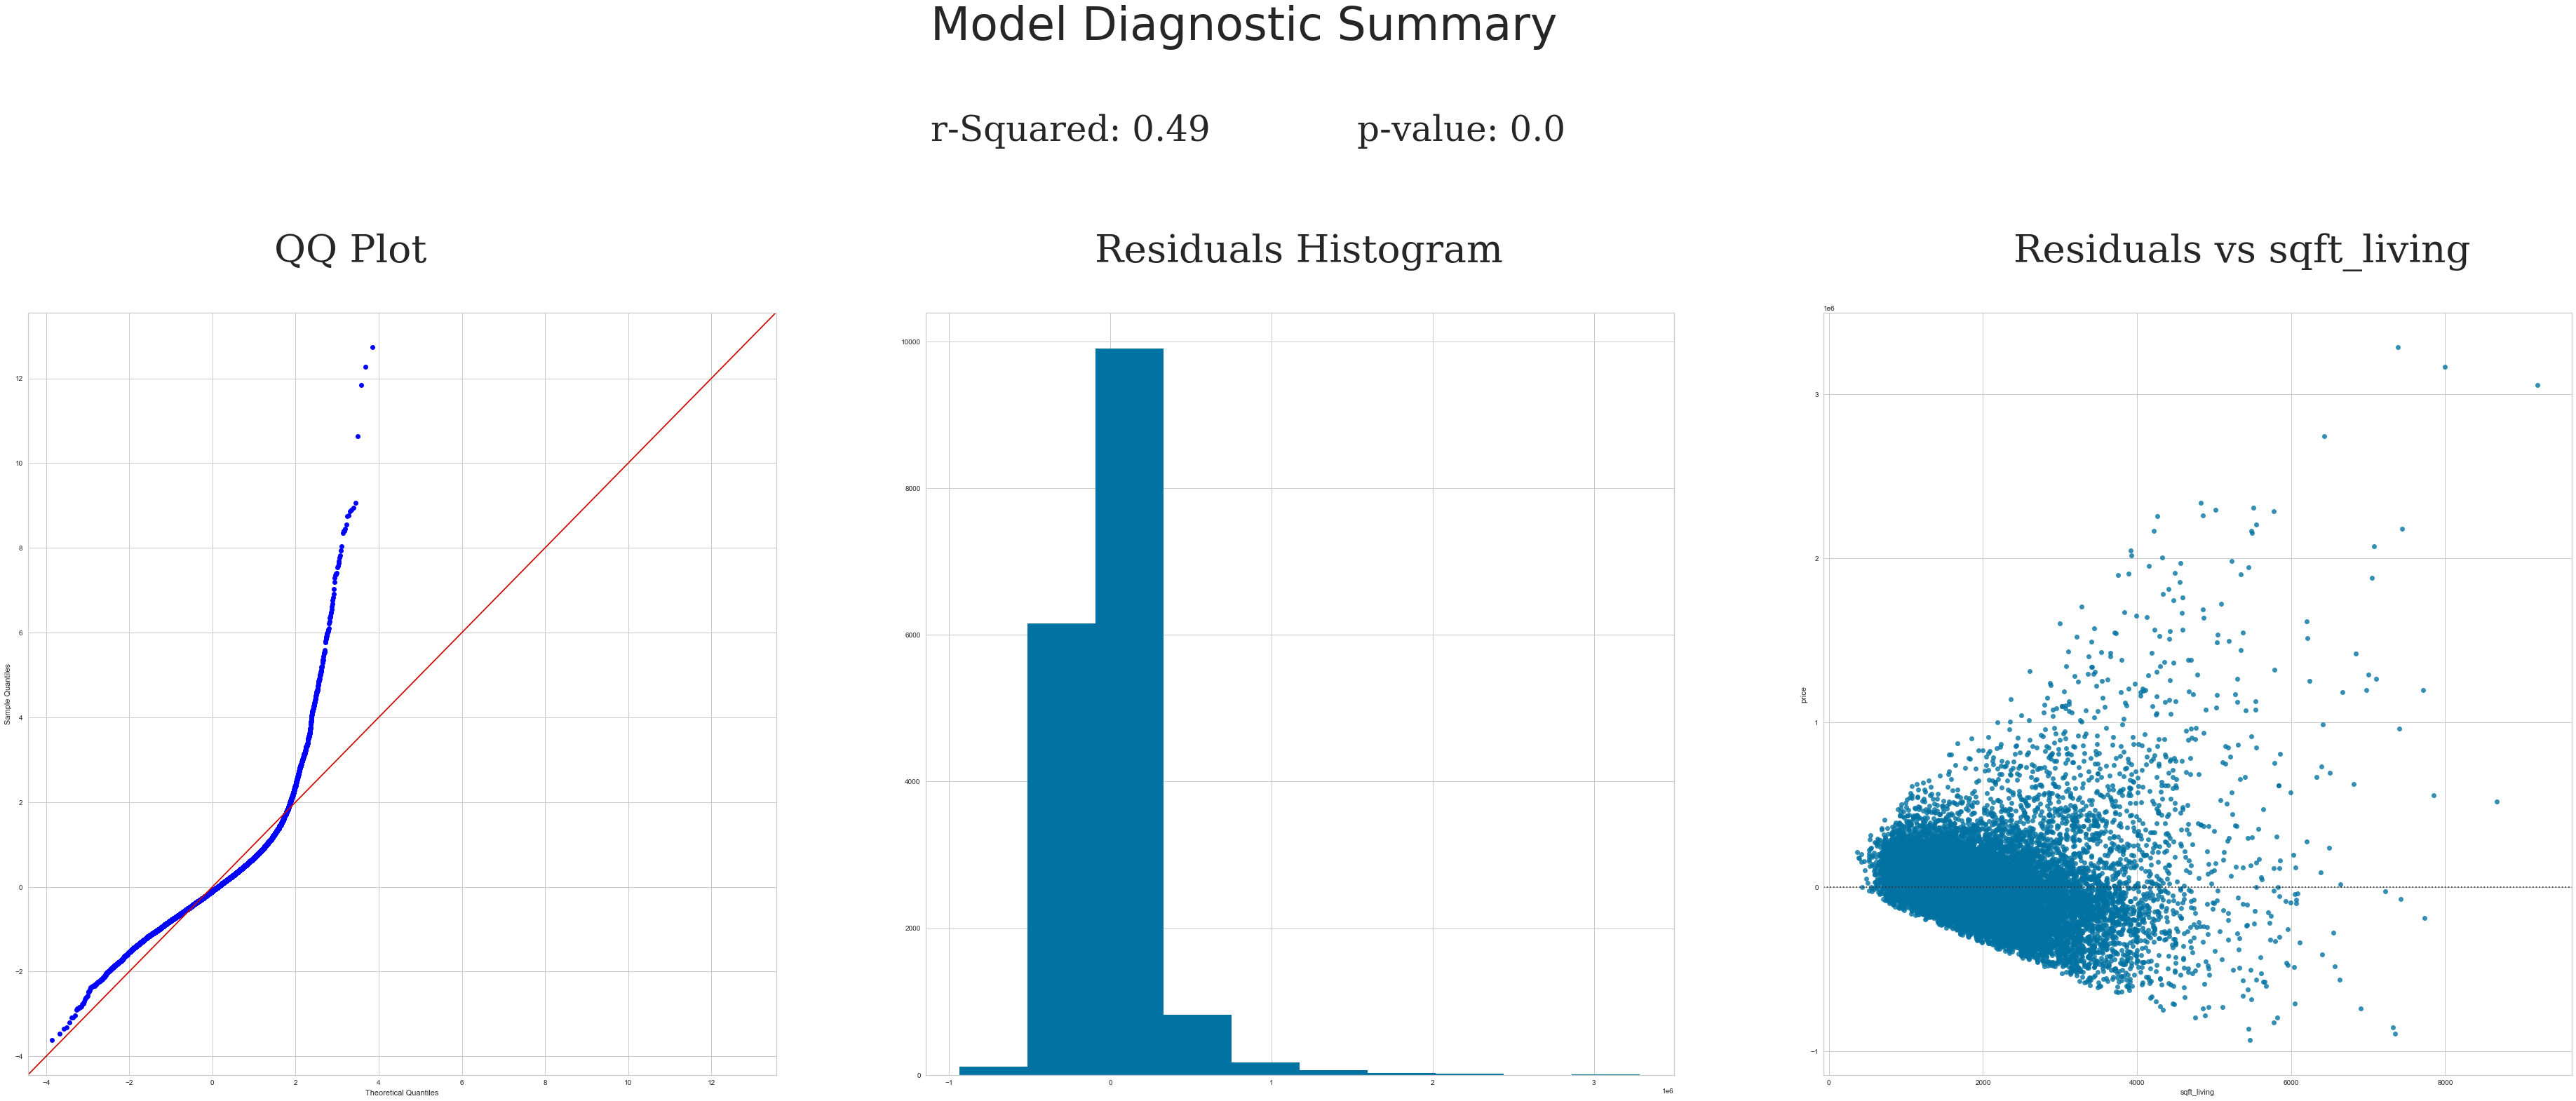

In [55]:
f = 'price~sqft_living'
sqft_living_model = smf.ols(formula=f, data=df).fit()
model_diagnostic(sqft_living_model, df['sqft_living'], 'sqft_living', df['price'])

<Figure size 576x396 with 0 Axes>

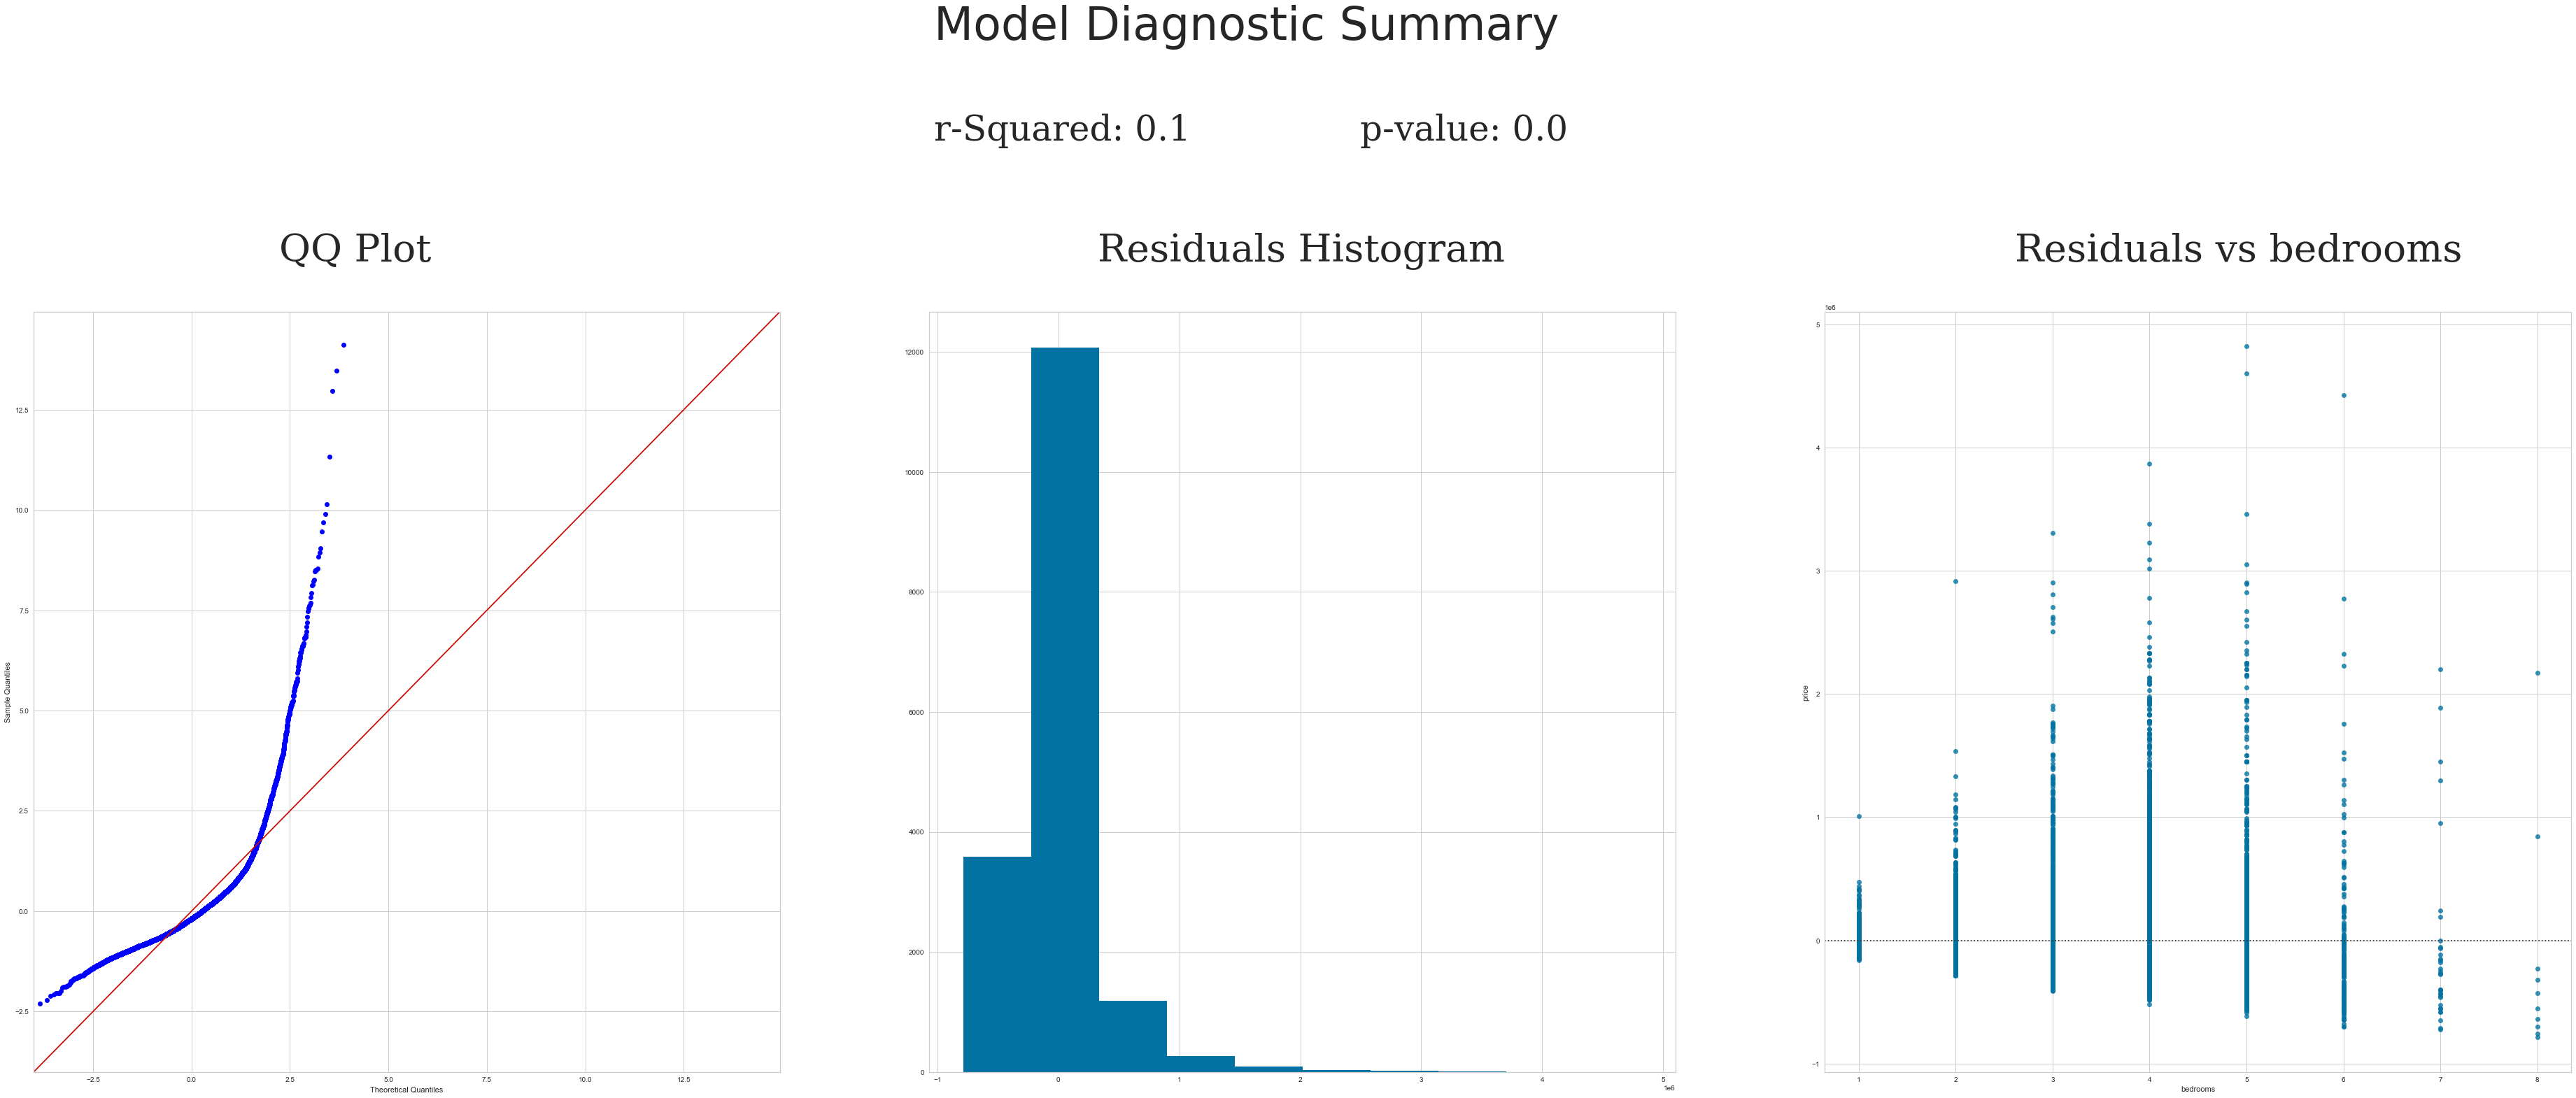

In [56]:
f = 'price~bedrooms'
bedrooms_model = smf.ols(formula=f, data=df).fit()
model_diagnostic(bedrooms_model, df['bedrooms'], 'bedrooms', df['price'])

<Figure size 576x396 with 0 Axes>

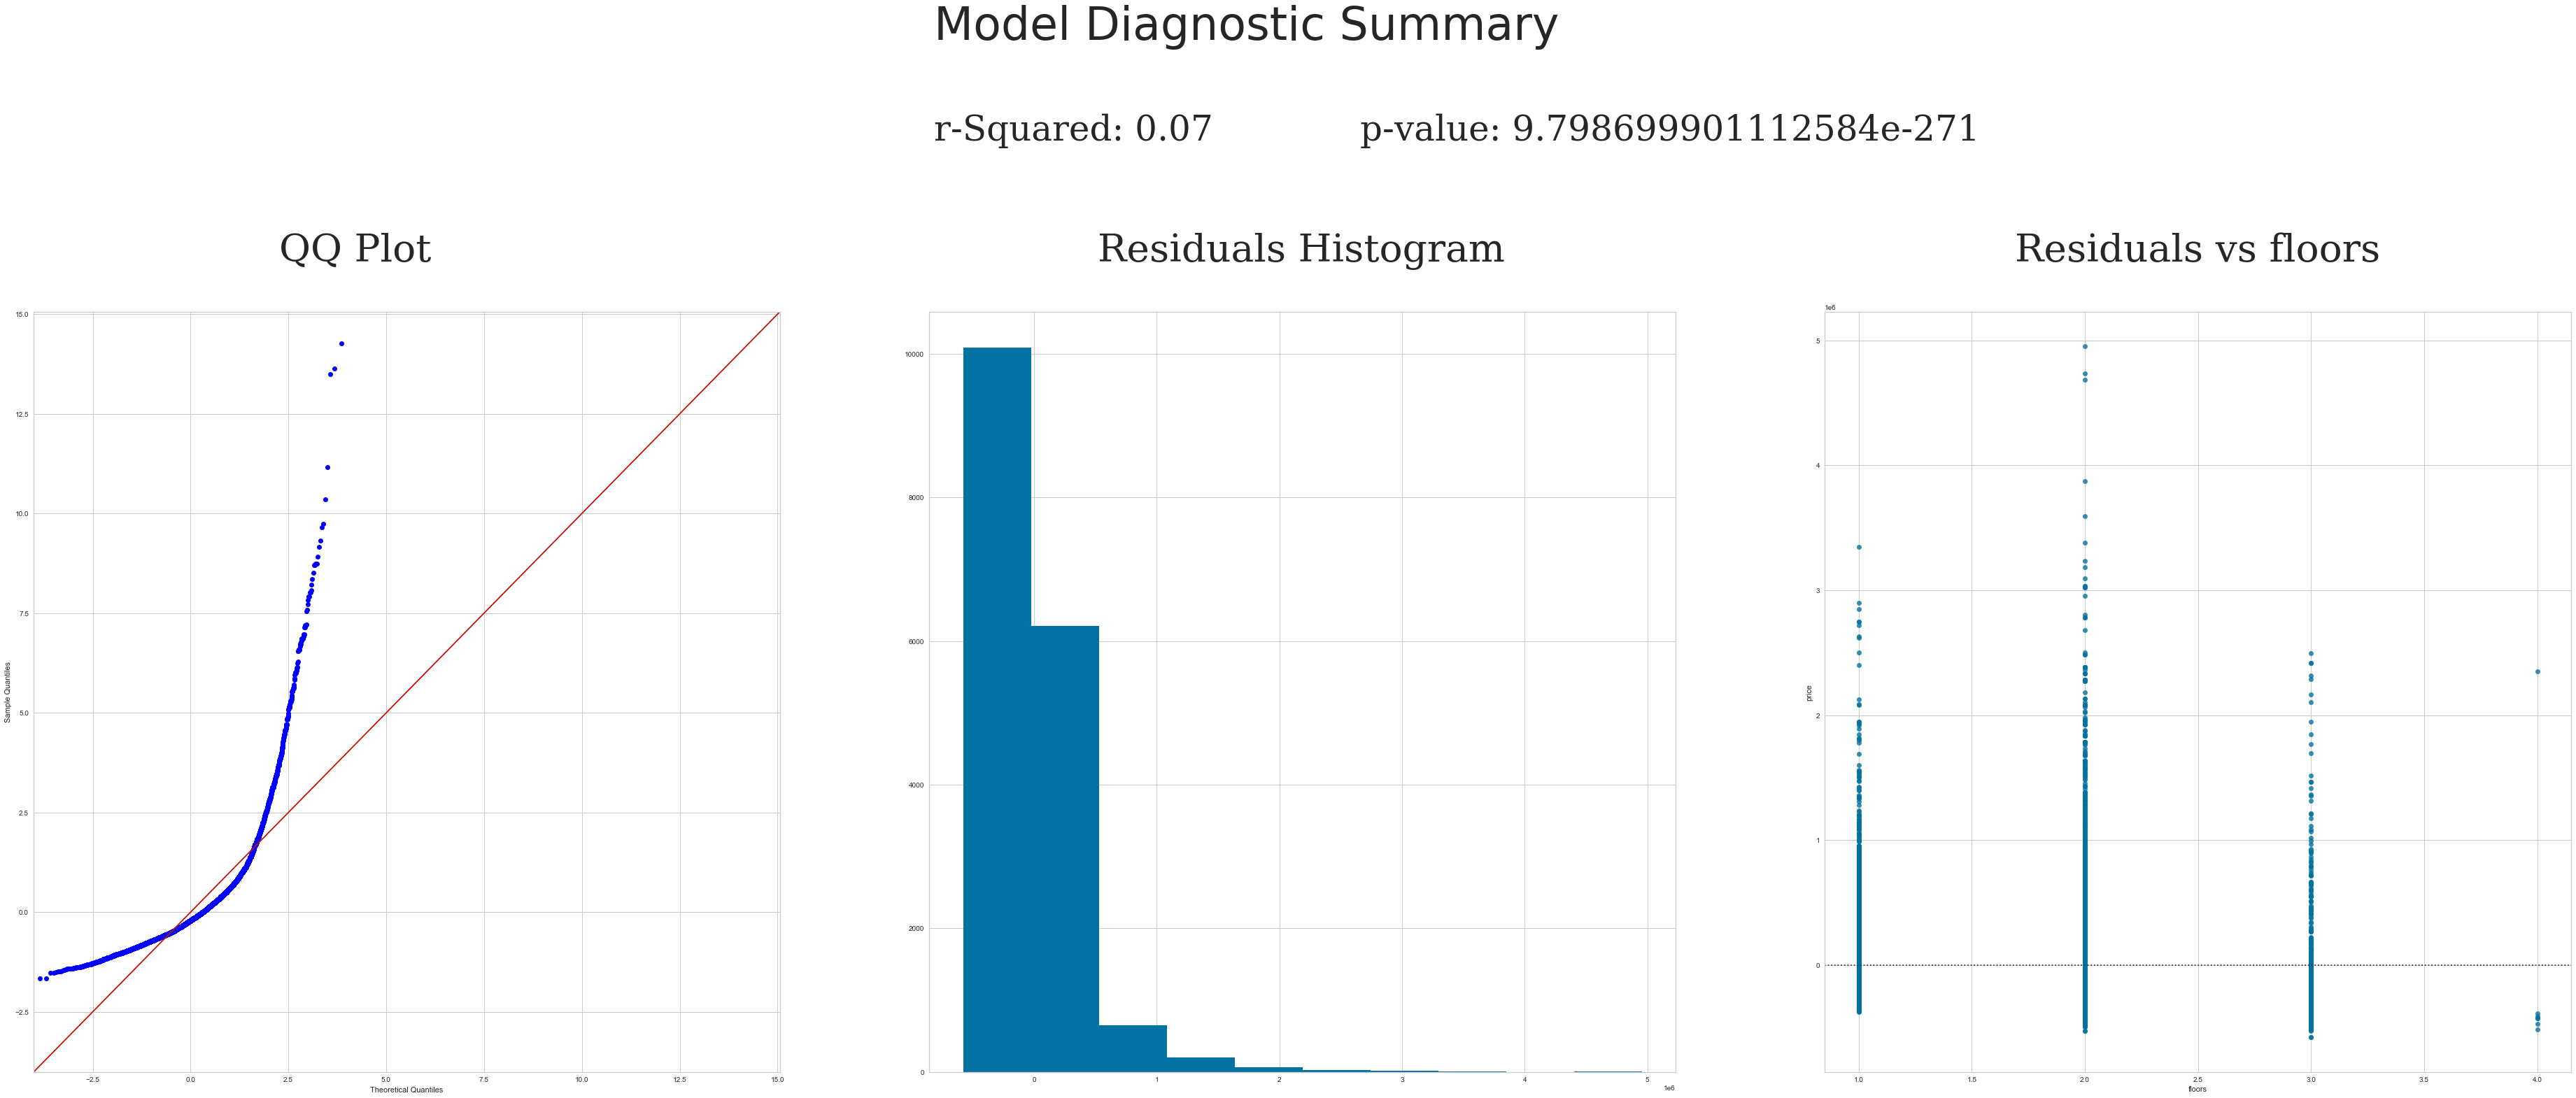

In [57]:
f = 'price~floors'
floors_model = smf.ols(formula=f, data=df).fit()
model_diagnostic(floors_model, df['floors'], 'floors', df['price'])

<Figure size 576x396 with 0 Axes>

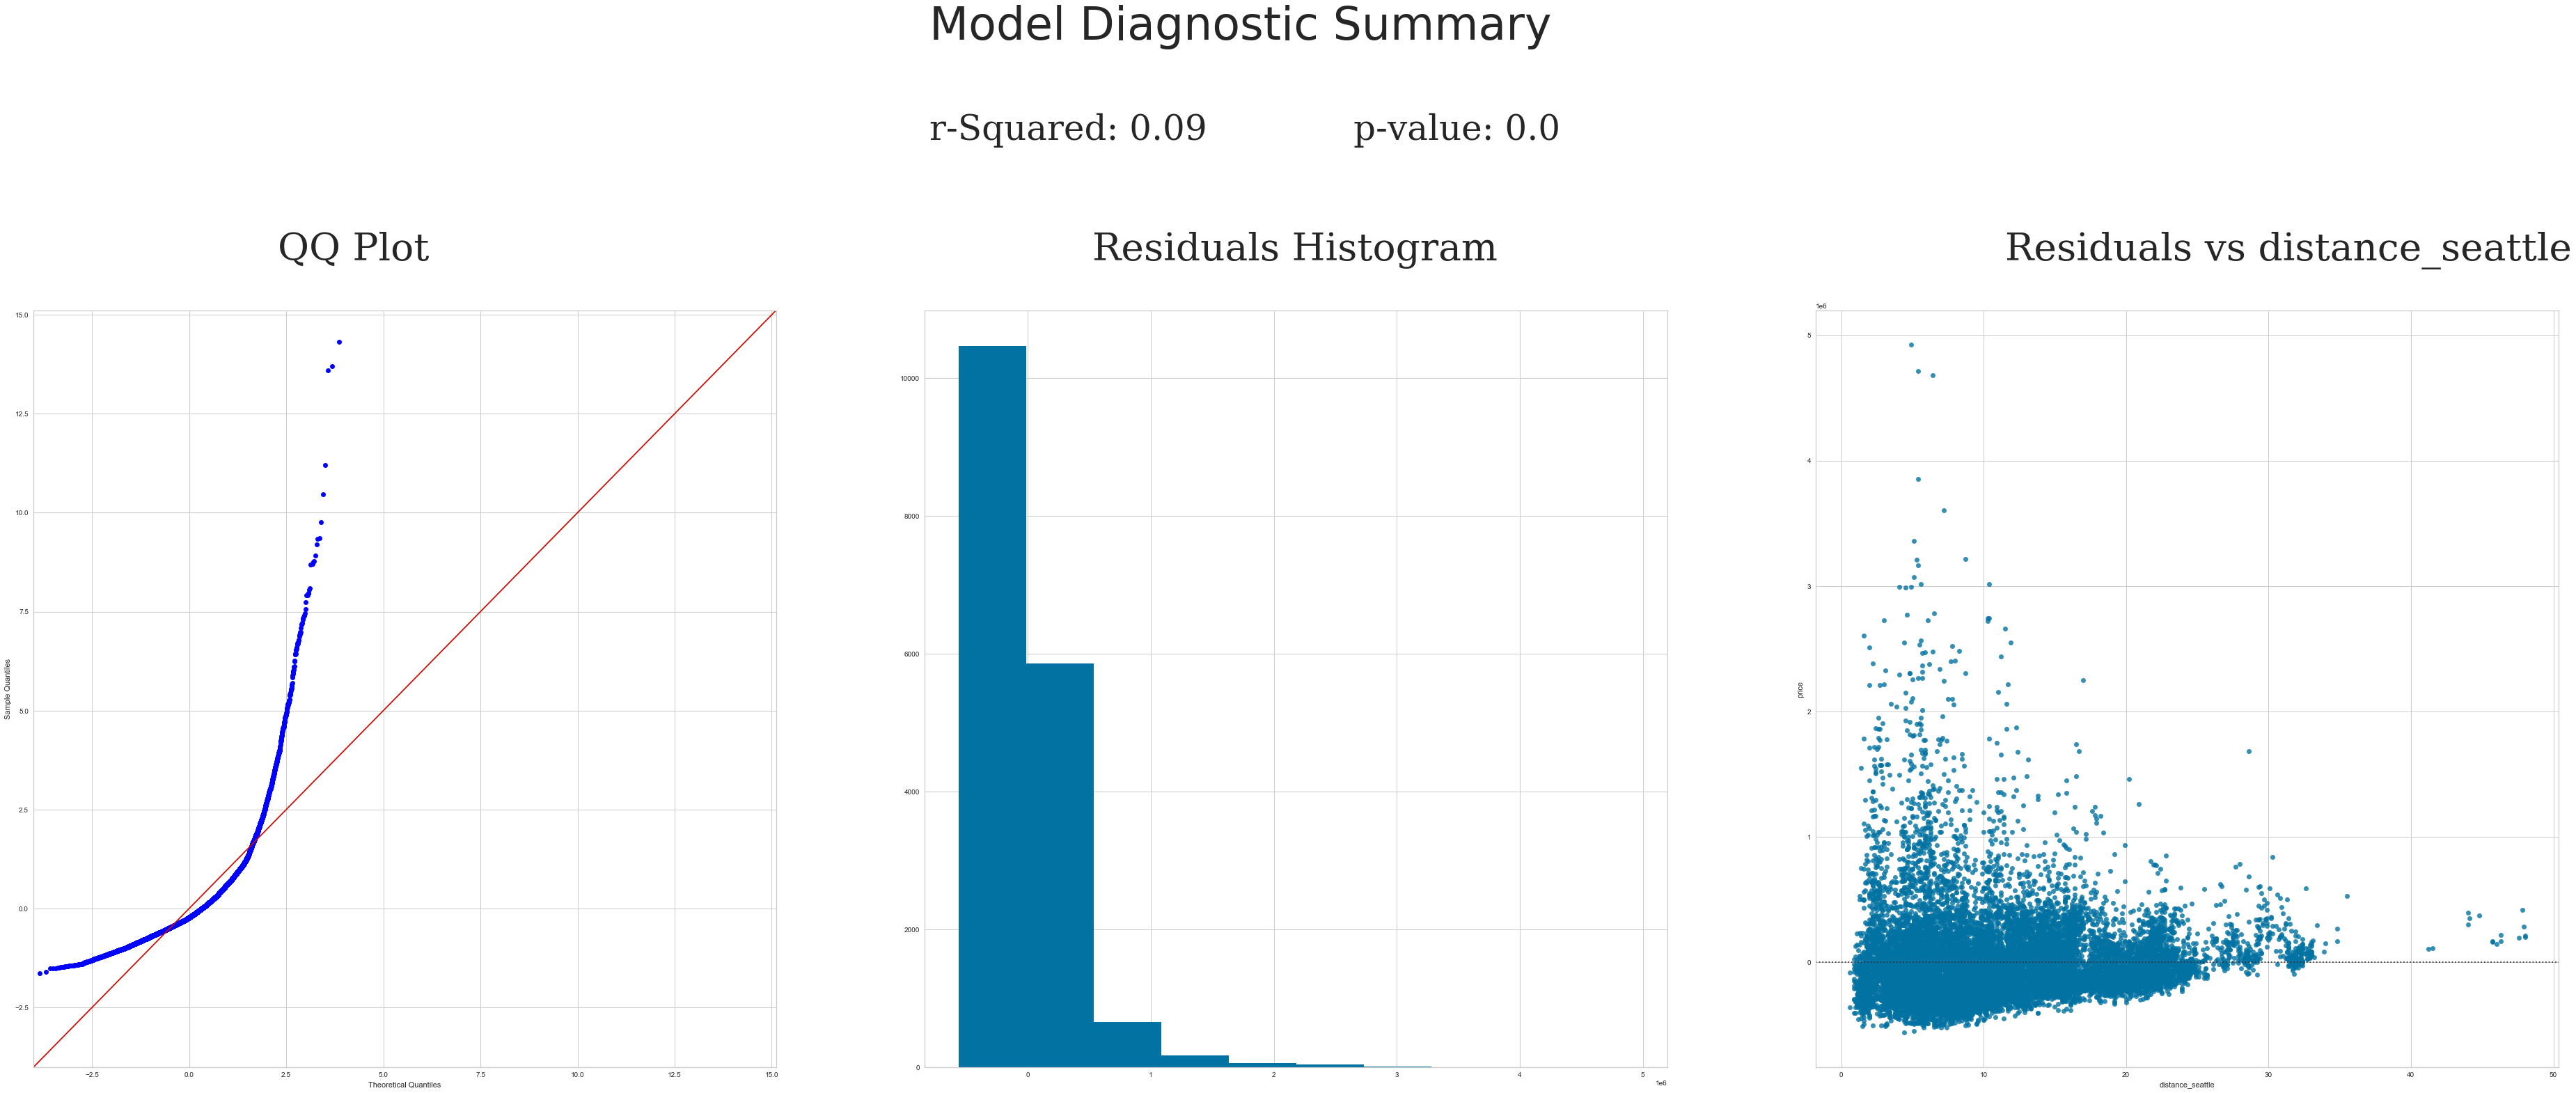

In [58]:
f = 'price~distance_seattle'
distance_seattle_model = smf.ols(formula=f, data=df).fit()
model_diagnostic(distance_seattle_model, df['distance_seattle'], 'distance_seattle', df['price'])

<Figure size 576x396 with 0 Axes>

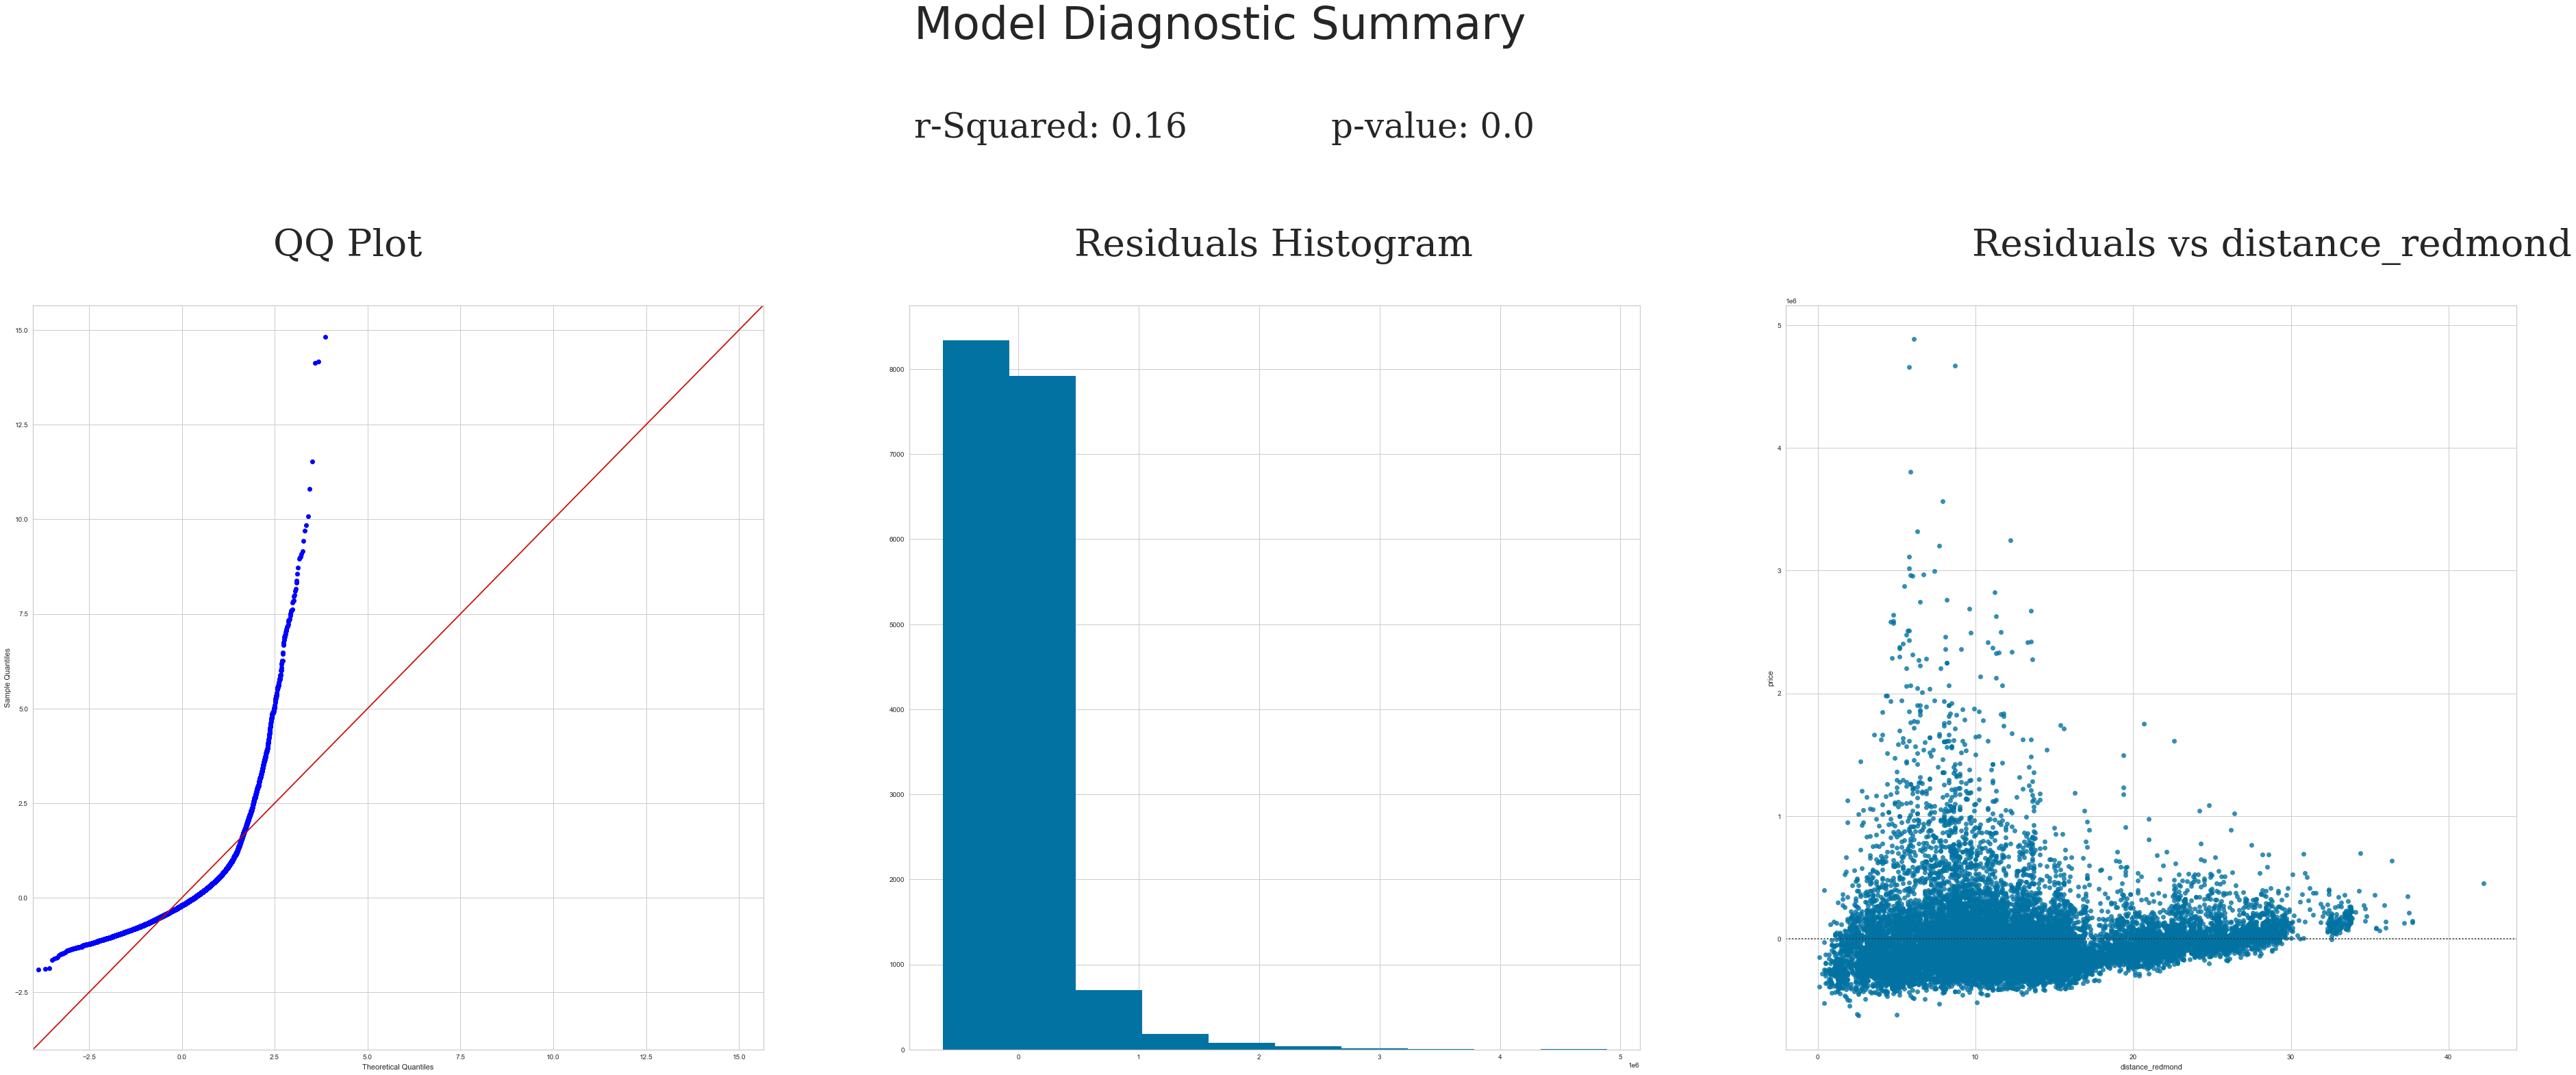

In [59]:
f = 'price~distance_redmond	'
distance_redmond_model = smf.ols(formula=f, data=df).fit()
model_diagnostic(distance_redmond_model, df['distance_redmond'], 'distance_redmond', df['price'])

In [60]:
# df['sqft_lot'].value_counts()

In [61]:
# df['sqft_lot'].hist()

data_log = pd.DataFrame([])
data_log['logsqft_living'] = np.log(df['sqft_living'])
logsqft_living = data_log['logsqft_living']
scaled_logdistance_seattle = (logdistance_seattle - np.mean(logdistance_seattle)) / np.sqrt(np.var(logdistance_seattle))

data_cont_scaled = pd.DataFrame([])
data_cont_scaled['sqft_living'] = scaled_logsqft_living

data_cont_scaled.hist(figsize = [6, 6]);

In [62]:
# fig, ax = plt.subplots(figsize=(12, 12))
# sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True);

Our Durbin-Watson value is close to 2, which indicates de model is homoscedastic.

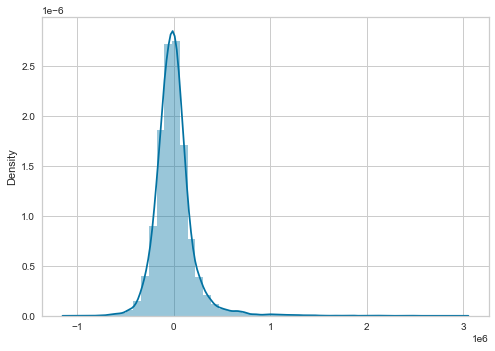

In [63]:
sns.distplot(model.resid);

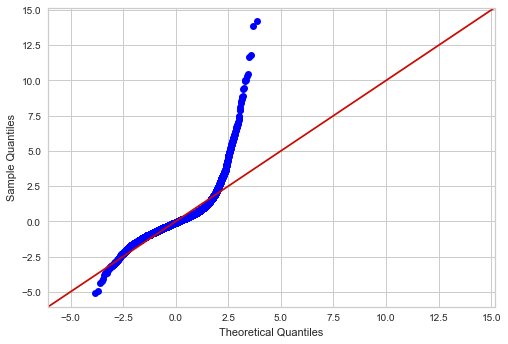

In [64]:
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

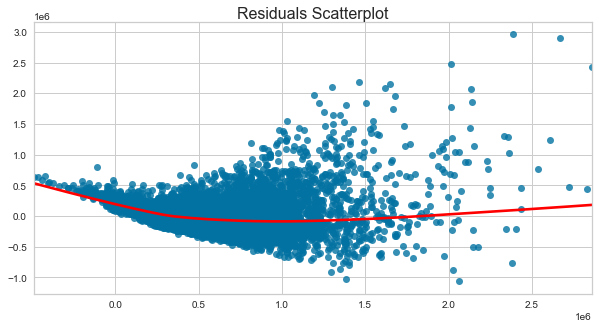

In [65]:
plt.figure(figsize=(10,5))
sns.regplot(x=model.predict(), y=model.resid, lowess=True, line_kws={'color': 'red'})
plt.title('Residuals Scatterplot', fontsize=16, y=.99);

In [66]:
from statsmodels.stats.diagnostic import het_goldfeldquandt
import statsmodels.stats.api as sms

name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(model.resid, model.model.exog)
list(zip(name, test))

[('F statistic', 0.9583855583130693), ('p-value', 0.9757707345435627)]

We fail to reject the null hypotesis here since the p-value is insignificant, so the model is homoscedastic.

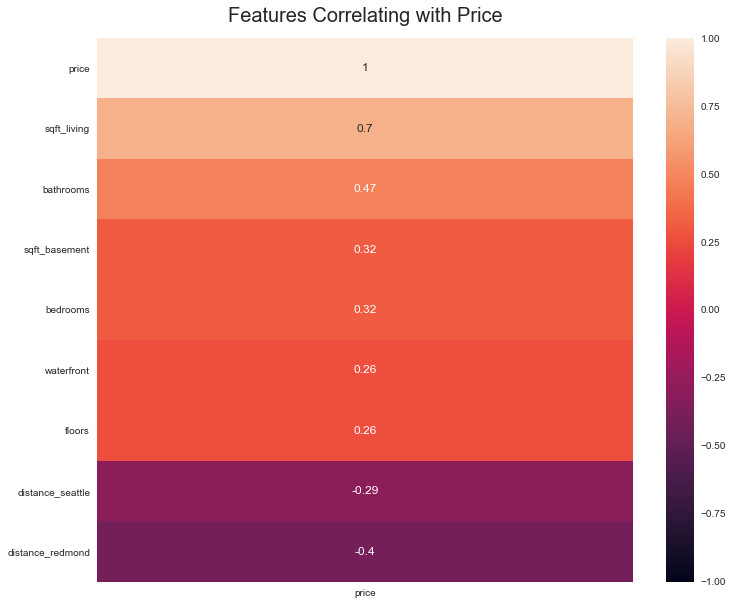

In [67]:
fig, ax = plt.subplots(figsize=(12, 10))
heatmap = sns.heatmap(df.corr()[['price']].sort_values(by='price', ascending=False), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Features Correlating with Price', fontdict={'fontsize':20}, pad=16);

## Checking Assumptions for Linear Regression

In [68]:
df['bedrooms'].value_counts()

3    7836
4    5542
2    2189
5    1279
6     213
1     161
7      33
8      10
Name: bedrooms, dtype: int64

In [69]:
df['sqft_basement'].value_counts()

0       10606
600       172
500       168
800       159
700       158
        ...  
374         1
1525        1
2580        1
2500        1
415         1
Name: sqft_basement, Length: 280, dtype: int64

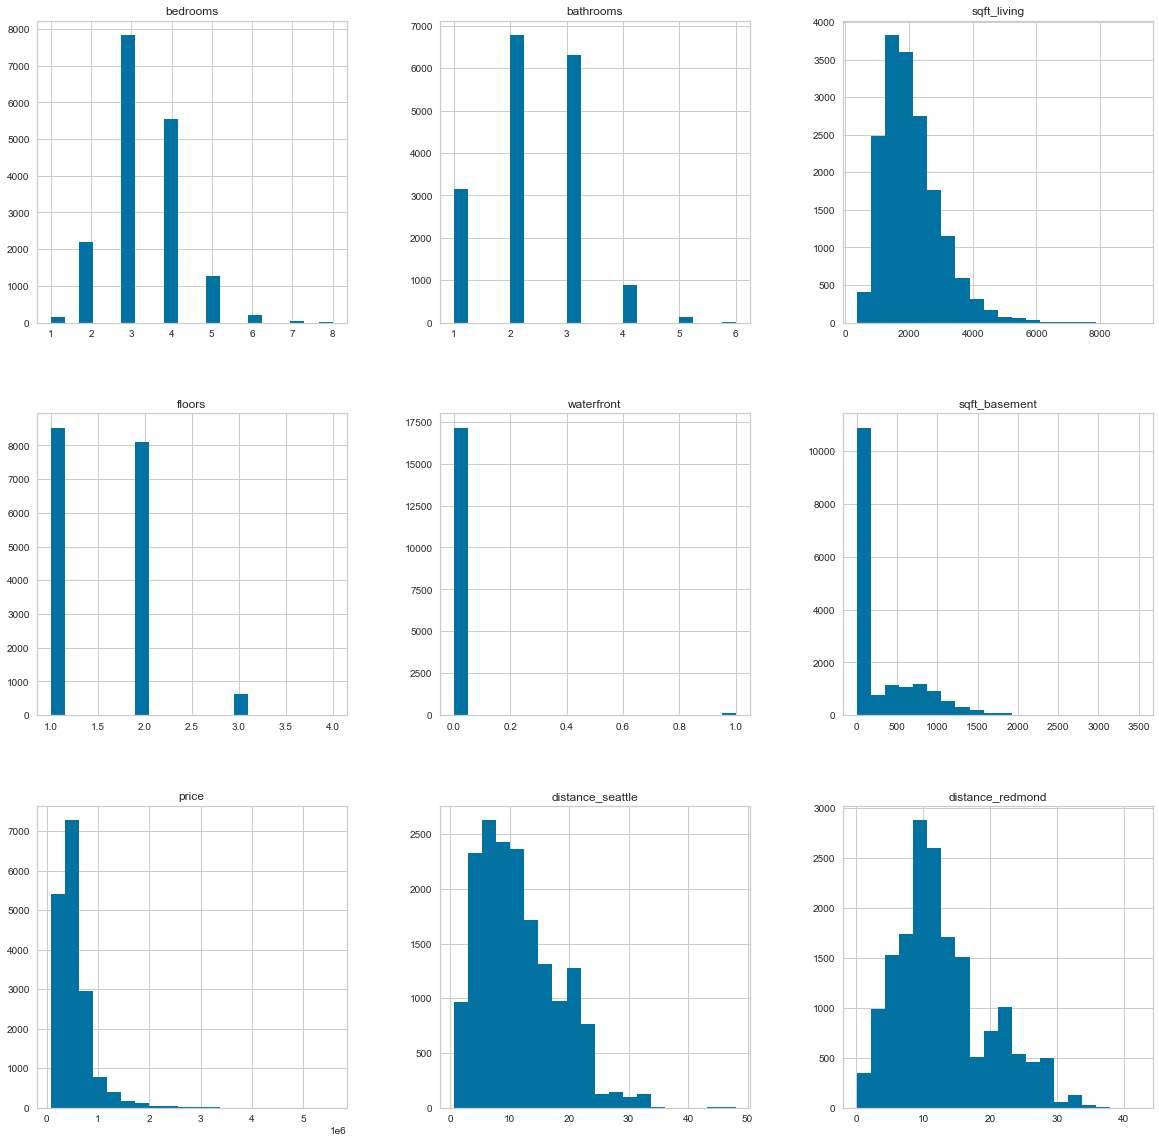

In [70]:
df.hist(figsize=(20,20), bins=20);

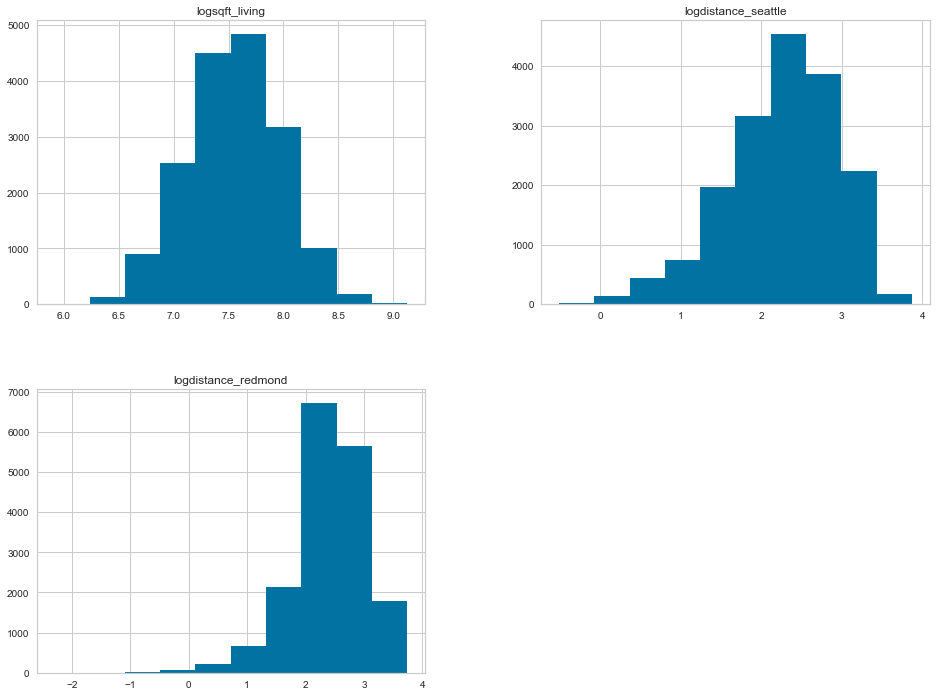

In [71]:
data_log = pd.DataFrame([])
data_log['logsqft_living'] = np.log(df['sqft_living'])
data_log['logdistance_seattle'] = np.log(df['distance_seattle'])
data_log['logdistance_redmond'] = np.log(df['distance_redmond'])
data_log.hist(figsize =[16, 12]);

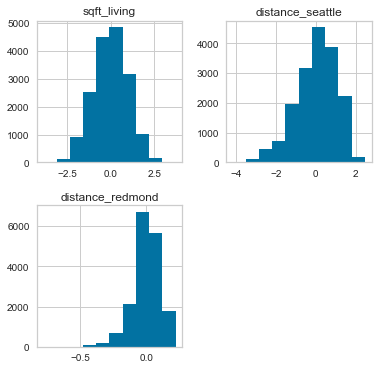

In [72]:

logsqft_living = data_log['logsqft_living']
logdistance_seattle = data_log['logdistance_seattle']
logdistance_redmond = data_log['logdistance_redmond']


scaled_logsqft_living = (logsqft_living - np.mean(logsqft_living)) / np.sqrt(np.var(logsqft_living))
scaled_logdistance_seattle = (logdistance_seattle - np.mean(logdistance_seattle)) / np.sqrt(np.var(logdistance_seattle))
scaled_logdistance_redmond = (logdistance_redmond - np.mean(logdistance_redmond)) / (max(logdistance_redmond) - min(logdistance_redmond))

data_cont_scaled = pd.DataFrame([])

data_cont_scaled['sqft_living'] = scaled_logsqft_living
data_cont_scaled['distance_seattle'] = scaled_logdistance_seattle
data_cont_scaled['distance_redmond'] = scaled_logdistance_redmond

data_cont_scaled.hist(figsize = [6, 6]);

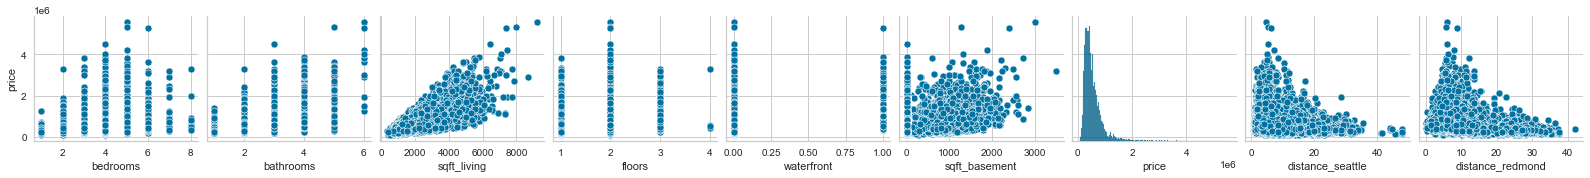

In [73]:
sns.pairplot(df, y_vars=['price'])

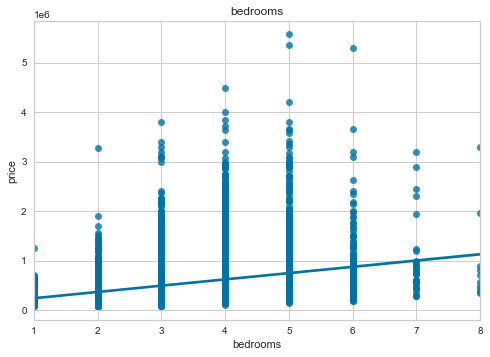

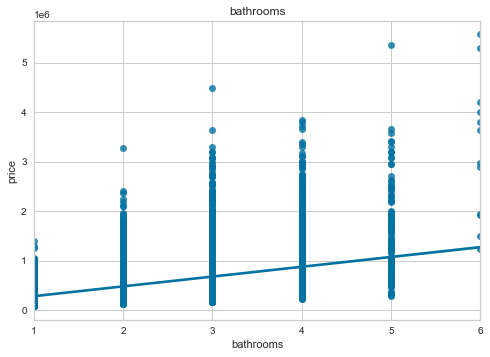

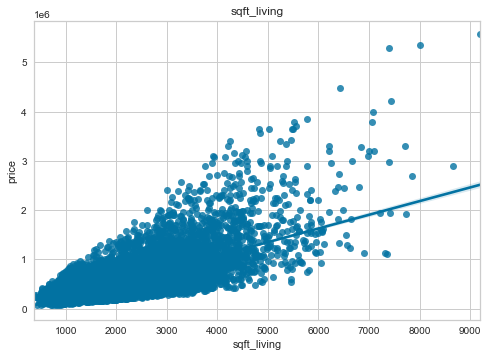

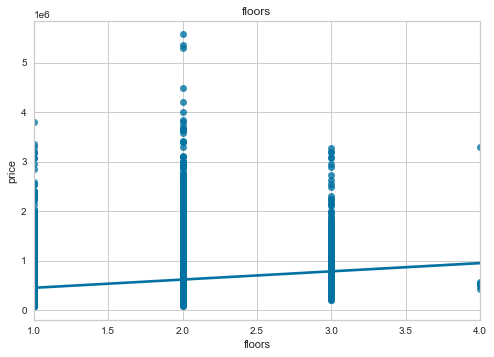

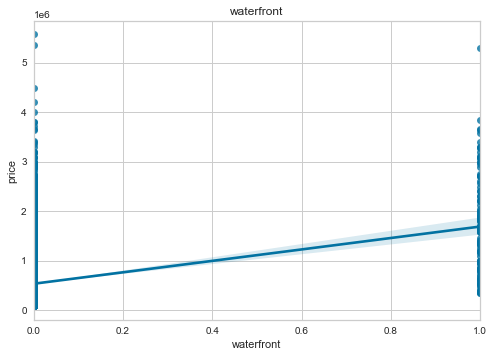

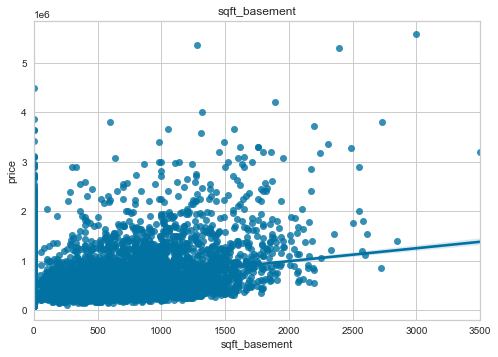

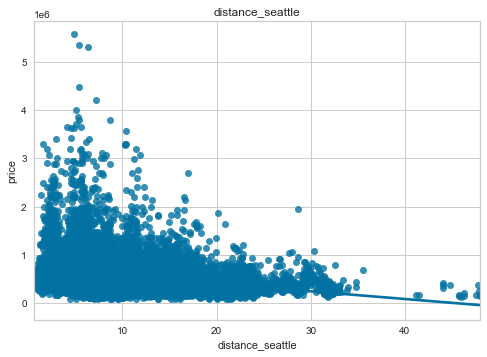

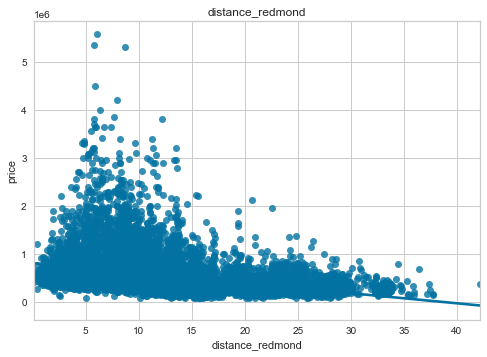

In [74]:
# X = df.drop('price', axis=1)
for col in X.columns:
    plt.subplots(1, 1)
    sns.regplot(X[col], df.price)
    plt.title(col)